This notebook attempts to back out neural scaling laws from datamodel coefficients.

It is based on the theory [here](https://ttw-public.notion.site/Datamodels-Per-datapoint-cliff-learning-491c8467f85e4d61be0026c1adb8b1d7).

### Load libraries

In [1]:
import pathlib

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

### Load paper data

In [2]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/cifar10/wpd-clean.csv")
df_bahri["loss"] = df_bahri.xent

df_rosenfeld = pd.read_csv(
    GIT_ROOT / "data/rosenfeld-cifar10/wpd-clean.csv"
)

### Read datamodels data

In [3]:
pcts = [10, 20, 50, 75]
dms = []

for pct in tqdm(pcts):
    dm = torch.load(
        f"/projects/scaling/datamodels/cifar10/test_{pct}pct.pt",
        map_location=torch.device("cpu"),
    )
    dms.append(dm)

dms[0]["weight"].shape, dms[0]["bias"].shape, dms[0].keys()

  0%|          | 0/4 [00:00<?, ?it/s]

(torch.Size([50000, 10000]),
 torch.Size([10000]),
 dict_keys(['lam', 'weight', 'bias', 'train_loss']))

What is `train_loss`? Note that it goes up with pct.

In [4]:
[dm["train_loss"].mean().item() for dm in dms]

[0.4719109833240509,
 0.7317387461662292,
 1.3007742166519165,
 1.3337242603302002]

### Preliminary datamodels analysis

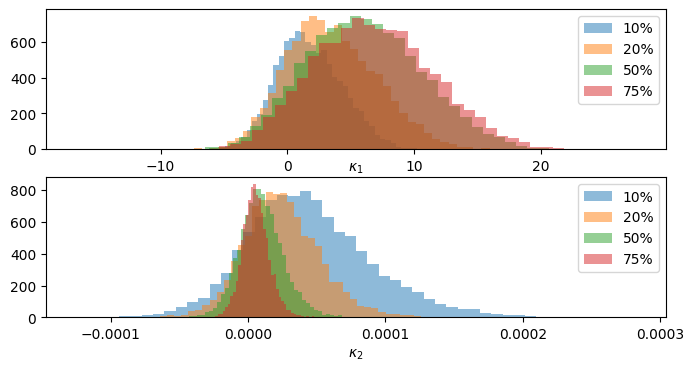

In [5]:
plt.figure(figsize=(8, 4))

plt.subplot(2, 1, 1)
for pct, dm in zip(pcts, dms):
    plt.hist(dm["bias"], bins=50, label=f"{pct}%", alpha=0.5)
plt.xlabel("$\kappa_1$")
# Move xlabel up
plt.gca().xaxis.set_label_coords(0.5, -0.08)
plt.legend()

plt.subplot(2, 1, 2)
for pct, dm in zip(pcts, dms):
    plt.hist(dm["weight"].mean(axis=0), bins=50, label=f"{pct}%", alpha=0.5)
plt.xlabel("$\kappa_2$")
plt.legend()

plt.show()

In [6]:
[(dm["weight"].mean(axis=0) < 0).float().mean() for dm in dms]

[tensor(0.1510), tensor(0.1761), tensor(0.2641), tensor(0.2726)]

The fact that 15% to 27% of test data points have a negative datamodels
$\kappa_2$ indiciates that datamodels are not useful for extrapolating
data-scaling laws.

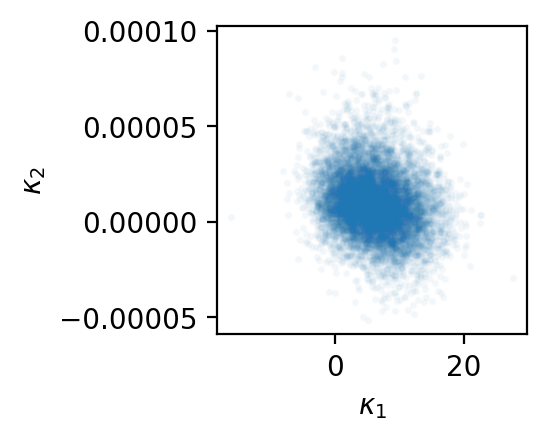

In [7]:
dm = dms[2]
plt.figure(figsize=(2, 2), dpi=200)
plt.scatter(dm["bias"], dm["weight"].mean(axis=0), s=3, alpha=0.03)
plt.xlabel("$\kappa_1$")
plt.ylabel("$\kappa_2$")
plt.show()

### Compute scaling law from datamodel

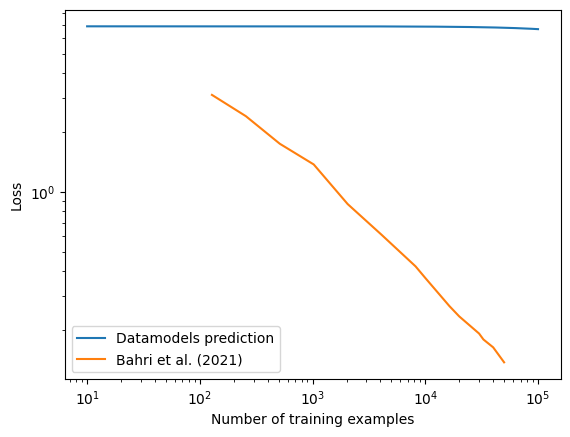

In [8]:
dm = dms[2]
k1s = dm["bias"].numpy()
k2s = dm["weight"].mean(axis=0).numpy()
# k2s = np.maximum(dm["weight"].mean(axis=0).numpy(), 0)

n_trains = np.logspace(start=1, stop=5, num=1000)
losses = np.log(
    1
    + np.exp(
        np.minimum(
            -k1s.reshape(1, -1) - k2s.reshape(1, -1) * n_trains.reshape(-1, 1),
            1e9,
        )
    ).mean(axis=-1)
)

plt.plot(n_trains, losses, label="Datamodels prediction")
plt.plot(
    df_bahri.n_train,
    df_bahri.loss,
    label="Bahri et al. (2021)",
    zorder=-1,
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel("Loss")
plt.legend()

plt.show()